In [1]:
# Imports

import numpy as np
import pandas as pd
import os, os.path
from itertools import *
%matplotlib inline
import matplotlib.pyplot as plt
import math
import random
import scipy.stats
import sys

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent data retrieval script

chromosomes = [1, 2, 6, 7, 11]
def chromosome_files(n):
    base = 'intersected_final_chr'
    spec = '_cutoff_20_'
    suffixes = ['train.bed', 'sample_partial.bed', 'sample_full.bed']
    return [base + str(n) + spec + suffix for suffix in suffixes]
all_chromosomes = set(chain.from_iterable(chromosome_files(n) for n in chromosomes))

if 'methylation_imputation' not in [x for x in os.listdir('.') if os.path.isdir(x)]:
    raise Exception('Missing assignment repository in cwd')

if not os.path.exists('data'):
    os.mkdir('data')

def have_chromosomes(): return all_chromosomes.issubset(set(os.listdir('data')))
if not have_chromosomes():
    ! gunzip -k -f methylation_imputation/data/*.bed.gz
    ! mv methylation_imputation/data/*.bed data/
    if not have_chromosomes():
        raise Exception('Error unpacking chromosomes data')

encode_file = 'wgEncodeRegTfbsClusteredV3.bed'
annotations_files = {encode_file}
def have_annotations(): return annotations_files.issubset(set(os.listdir('data')))
if not have_annotations():
    ! gunzip -k -f methylation_imputation/annotations/*.bed.gz
    ! mv methylation_imputation/annotations/*.bed data/
    if not have_annotations():
        raise Exception('Error unpacking ENCODE data')

def read_tsv(name): return pd.read_csv(name, sep='\t', header=None)
train_chr1 = read_tsv('data/' + chromosome_files(1)[0])
test_chr1_partial = read_tsv('data/' + chromosome_files(1)[1])
test_chr1_full = read_tsv('data/' + chromosome_files(1)[2])

unknown_chr1_ix = np.where((test_chr1_partial[5] == 0) & ~np.isnan(test_chr1_full[4]))[0]
known_chr1_ix = np.where((test_chr1_partial[5] == 1) & ~np.isnan(test_chr1_partial[4]))[0]

test_ix = unknown_chr1_ix
train_ix = known_chr1_ix

train_df = train_chr1
train_tissues = ['b' + str(x) for x in range(train_chr1.shape[1] - 4)]
train_df.columns = ['chromosome', 'start', 'end', 'strand'] + train_tissues

test_df = test_chr1_full
test_df.columns = ['chromosome', 'start', 'end', 'strand', 'filled', 'assayed']
test_df['missing'] = test_chr1_partial[4]

train_df['strand'] = train_df['strand'] == '+'
test_df['strand'] = test_df['strand'] == '+'

In [2]:
# Add CRE info
rawe = read_tsv('data/' + encode_file)
rawe.drop([4, 5, 6, 7], axis=1, inplace=True)
rawe.columns = ['chromosome', 'start', 'end', 'tf']
tfs = set(rawe['tf'])

# This may take a minute
from intervaltree import IntervalTree, Interval
iv_chr1 = IntervalTree((Interval(*x[1]) for x in
                       rawe[rawe['chromosome'] == 'chr1'][['start', 'end', 'tf']].iterrows()))
def inside_tf(row):
    overlap = [x.data for x in iv_chr1[row['start']:row['end']]]
    return pd.Series({tf: (tf in overlap) for tf in tfs})
# This may take 3 minutes
train_df = train_df.merge(train_df[['start', 'end']].apply(inside_tf, axis=1), copy=False,
                          left_index=True, right_index=True)

import gc
iv_chr1 = rawe = None
gc.collect()
pass

In [3]:
print('Num train tissues', len(train_tissues))
print('Num trans factors', len(tfs))
train_df.loc[range(267, 273)]

Num train tissues 34
Num trans factors 161


,chromosome,start,end,strand,b0,b1,b2,b3,b4,b5,...,YY1,ZBTB33,ZBTB7A,ZEB1,ZKSCAN1,ZNF143,ZNF217,ZNF263,ZNF274,ZZZ3
267,chr1,121511,121513,True,0.714286,0.739130,0.800000,0.782609,0.794872,0.750000,...,False,False,False,False,False,False,False,False,False,False
268,chr1,121516,121518,True,0.857143,0.800000,0.833333,0.913043,0.909091,0.806452,...,False,False,False,False,False,False,False,False,False,False
269,chr1,122736,122738,False,0.545455,0.384615,0.472727,NaN,0.436364,0.580000,...,False,False,False,False,False,False,False,False,False,False
270,chr1,122869,122871,False,0.837838,0.814815,0.725000,0.807692,0.710526,0.565217,...,False,False,False,False,False,False,False,False,False,False
271,chr1,122884,122886,False,0.842105,0.821429,0.720930,0.800000,0.795455,0.478261,...,False,False,False,False,False,False,False,False,False,False
272,chr1,127749,127751,True,0.633333,0.473684,0.703704,0.611111,0.827586,0.666667,...,False,False,False,False,False,False,False,False,False,False


In [4]:
assert len(train_df) == len(test_df)
def count_unique(col):
    return {x:sum(col == x) for x in set(col)}

print('Chromosome 1')
print('Total samples', len(train_df))
print('Site lengths', count_unique(train_df['end'] - train_chr1['start']))
print('Strand types', count_unique(train_df['strand']))
print('Known (test) sample site counts', len(known_chr1_ix))
print('Unknown (test) sample site counts', len(unknown_chr1_ix))
print('NaN ratio in all train samples',
      sum(sum(np.isnan(train_df[train_tissues].values))) / (len(train_df) * len(train_tissues)))
print('NaN ratio in test', sum(np.isnan(test_df['missing'])) / len(test_df))
assert sum(test_df['strand'] != train_df['strand']) == 0

Chromosome 1
Total samples 379551
Site lengths {2: 379551}
Strand types {False: 1464, True: 378087}
Known (test) sample site counts 7523
Unknown (test) sample site counts 368411
NaN ratio in all train samples 0.0849950103582
NaN ratio in test 0.980179211753


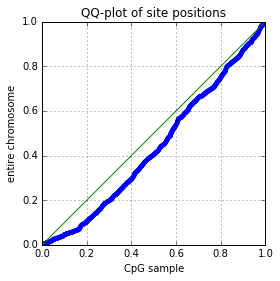

avg length between known sites 50.2903483116
sd of number of bp between sites 86.9614546017


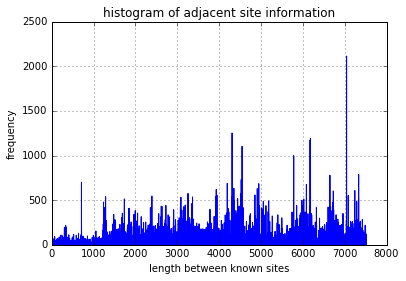

In [5]:
# Make sure our samples are pretty uniform from the genomic range
def ticks(n): return np.arange(0.0, n) / n
plt.plot(ticks(len(known_chr1_ix)), known_chr1_ix / len(train_df), '.')
plt.plot([0, 1])
plt.axes().set_aspect('equal')
plt.xlabel('CpG sample')
plt.ylabel('entire chromosome')
plt.title('QQ-plot of site positions')
plt.grid(True)
plt.show()

diffs = np.diff(known_chr1_ix)
print('avg length between known sites', np.mean(diffs))
print('sd of number of bp between sites', np.std(diffs))
plt.plot(np.diff(known_chr1_ix))
plt.xlabel('length between known sites')
plt.ylabel('frequency')
plt.title('histogram of adjacent site information')
plt.grid(True)
plt.show()

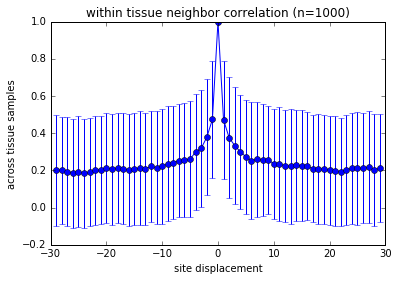

In [6]:
# Observe nearby site correlations
def drop_nan_corr(x, y):
    ix = np.where(~np.isnan(y) & ~np.isnan(x))
    return scipy.stats.pearsonr(x[ix], y[ix])[0]
# Choose a random site, check neighbors within vicinity of 'reach'
reach = list(range(30))
reach = [-x for x in reversed(reach)] + reach[1:]
def sample_corr(reach):
    site = random.randint(max(reach), len(train_chr1) - max(reach) - 1)
    y = np.array(train_df.iloc[site][train_tissues[:-1]]
                 .values).astype(np.float64)
    nbrs = [site + i for i in reach]
    xs = np.array(train_df.iloc[nbrs][train_tissues[:-1]]
                  .values).astype(np.float64)
    return np.array([drop_nan_corr(x, y) for x in xs])

sample = 1000
test = np.array([sample_corr(reach) for i in range(sample)])
plt.errorbar(reach, np.mean(test, axis=0), fmt='-o', yerr=np.std(test, axis=0))
plt.title('within tissue neighbor correlation (n={})'.format(sample))
plt.ylabel('across tissue samples')
plt.xlabel('site displacement')
plt.show()

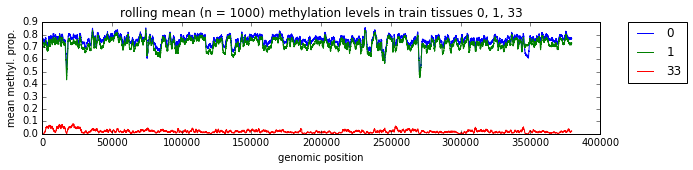

orig : rolling mean stddevs [4.8264430391409112, 4.6245001454552384, 11.339790875795508]


In [7]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

plt.figure(figsize=(10, 2))
ratios = []
plt.title('rolling mean (n = 1000) methylation levels in train tissues 0, 1, 33')
plt.xlabel('genomic position')
plt.ylabel('mean methyl. prop.')

x = local_impute(np.copy(train_df['b0']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l0, = plt.plot(rolled, label='0')

x = local_impute(np.copy(train_df['b1']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l1, = plt.plot(rolled, label='1')

x = local_impute(np.copy(train_df['b33']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l33, = plt.plot(rolled, label='33')

plt.legend(handles=[l0, l1, l33])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print('orig : rolling mean stddevs', ratios)

In [8]:
# Sparsity
print('Training tissue sparsities', [(train_df[i] <= 0.01).sum() / len(train_df) for i in train_tissues])
print('Sample sparsity', (test_df['filled'][train_ix] <= 0.01).sum() / len(train_ix))

Training tissue sparsities [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97994999354500445]
Sample sparsity 0.0


In [9]:
# Do mean imputation on our training data.
def mean_impute(data):
    mask = np.isnan(data)
    data[mask] = float(data.mean()) # just = m messes with serialization
    return data
train_df_imp = train_df
train_df_int = train_df
for i in train_tissues:
    train_df_imp[i] = mean_impute(train_df[i].copy())
    train_df_int[i] = local_impute(train_df[i].copy())
print('nans in mean-imputed', np.isnan(train_df_imp[train_tissues]).sum().sum())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in mean-imputed 0
nans in interpolated 0


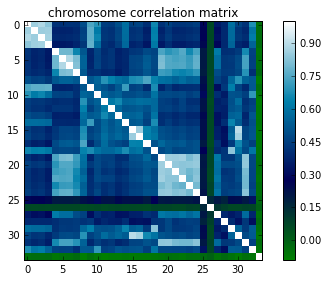

closest to test sample based on training data: 19


In [10]:
corr_mat = [[scipy.stats.pearsonr(train_df_imp
                                  [a], train_df_imp[b])[0]
             for a in train_tissues] for b in train_tissues]
plt.imshow(corr_mat, interpolation='nearest', cmap=plt.cm.ocean)
plt.title('chromosome correlation matrix')
plt.colorbar()
plt.tight_layout()
plt.show()

def pandas_rmse(a, b):
    # http://stackoverflow.com/questions/27783494/root-mean-square-error-of-two-pandas-series
    return math.sqrt(a.sub(b).pow(2).mean())

l = [pandas_rmse(train_df_imp[t].iloc[train_ix], test_df['filled'][train_ix]) for t in train_tissues]
print('closest to test sample based on training data:', l.index(min(l)))

In [11]:
# We'll only test on the well-behaved chromosomes similar to our
# test chromosome according to the cluster above, testable:
testable_tissues = ['b' + str(i) for i in range(19, 25)]
closest = 'b19'
# this is just an eyeball selection, but should prove good enough to
# offer decent generalization via cross validation.

In [12]:
# Define some evaluation functions

from sklearn.metrics import r2_score

def denanify(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    assert mask.sum() > 0
    return a[mask], b[mask]

def correct_half(a, b):
    methylated_guess = a >= 0.5
    methylated_exact = b >= 0.5
    return (methylated_guess == methylated_exact).sum() / len(methylated_guess)

# Function f should return its estimate for the value in 'test_tissue'
# at each test_ix location. It gets its own copy of test_tissue, but
# train_cols is shared.
def eval_fold(f, train_cols, test_tissue, train_tissue_names):
    nanned = test_tissue.copy()
    nanned[test_ix] = np.nan
    guess = f(train_cols, nanned, train_tissue_names)
    assert sum(np.isnan(guess)) == 0
    # test_ix doesn't have nans in the test_df['filled'] col, but
    # within train_df there might be nans here.
    exact = test_tissue[test_ix]
    if not isinstance(guess, pd.Series):
        guess = pd.Series(guess, index=exact.index)
    assert len(guess) == len(exact)
    guess, exact = denanify(guess, exact)
    return np.array([pandas_rmse(guess, exact), correct_half(guess, exact),
                     r2_score(exact, guess)])

from joblib import Parallel, delayed
nproc = 4

# Excludes the sparse chromosome from testing.
def cv_folds(f, df=train_df, threading='multiprocessing',
             additional_cols=[], test_tissues=testable_tissues):
    rmse_acc = np.zeros(3)
    ctr = 0
    arguments = []
    for t in test_tissues:
        train_cols = train_tissues[:]
        train_cols.remove(t)
        arguments.append((f, df[train_cols + additional_cols], df[t], train_cols))
    folds = [eval_fold(*i) for i in arguments] if not threading else \
            Parallel(n_jobs=nproc, backend=threading) \
                (delayed(eval_fold)(*i) for i in arguments)
    return sum(folds) / len(folds)

def perfstr(rmse_acc):
    return 'rmse {} methylated acc {} R^2 {}'.format(*rmse_acc)

In [13]:
# No trends.
# Let's try imputing from but clearly we can impute from local neighbor data.
# Try using no information for our test chromosome as a baseline.

# Two simple approaches, with no information from other samples

def interpolation(cols, partial, train_tissue_names):
    return local_impute(partial).iloc[test_ix]
print('interpolation', perfstr(cv_folds(interpolation)))

def same_sample_mean(cols, partial, train_tissue_names):
    return mean_impute(partial).iloc[test_ix]
print('same tissue mean', perfstr(cv_folds(same_sample_mean)))

interpolation rmse 0.20477740780970047 methylated acc 0.8897997073920161 R^2 -0.6131129817291857
same tissue mean rmse 0.16247889234653728 methylated acc 0.9376303458184835 R^2 -0.015392692439529601


In [14]:
# As a dual approach, we can try using only information from the remaining tissues
# For example, we might try to take a mean of methylation values along the same site
def diff_sample_mean(cols, partial, train_tissue_names):
    return cols[train_tissue_names].iloc[test_ix].mean(axis=1)
print('diff tissue mean', perfstr(cv_folds(diff_sample_mean)))

diff tissue mean rmse 0.1318694424931256 methylated acc 0.9536961889483936 R^2 0.3256145169853153


In [15]:
def nearest_neighbor(cols, partial, train_tissue_names):
    nbr = min((pandas_rmse(cols[t].iloc[train_ix], partial.iloc[train_ix]), t)
              for t in train_tissue_names)[1]
    return cols[nbr].iloc[test_ix]
print('1NN', perfstr(cv_folds(nearest_neighbor, df=train_df_imp)))

1NN rmse 0.09120396089592973 methylated acc 0.968845483260091 R^2 0.6777635739603453


In [16]:
# Use the well-formedness of the other-tissue data to train a basic lm
def sklearn_model(lm, cols, partial, train_tissue_names):
    lm.fit(cols.iloc[train_ix], partial.iloc[train_ix])
    return lm.predict(cols.iloc[test_ix])

from functools import partial
from sklearn import linear_model
from sklearn import ensemble
def log_range(lo, hi): return [10 ** i for i in range(lo, hi)]

def sklearn_model_only_metadata(lm, cols, partial, train_tissue_names):
    f = list(set(cols.columns) - set(train_tissue_names))
    lm.fit(cols[f].iloc[train_ix], partial.iloc[train_ix])
    return lm.predict(cols[f].iloc[test_ix])

lmmodels = [
    ('OLS', linear_model.LinearRegression()),
    ('Ridge', linear_model.RidgeCV(alphas=log_range(-1, 4), cv=8)),
    ('Lasso', linear_model.LassoCV(alphas=log_range(-6,-1), cv=8)),
    ('RFR', ensemble.RandomForestRegressor(n_estimators=100)),
    ('ElasticNet', linear_model.ElasticNetCV(l1_ratio=np.arange(.1, 1, .1),
                                             alphas=log_range(-5, 5), cv=8)),
    #('ARDRegression', linear_model.ARDRegression())
]

df = train_df_int
#df = train_df_imp

def run_models(cv_fun):
    best = None, [None, None, -np.inf], None
    for name, model in lmmodels:
        perf = cv_fun(model)
        if perf[2] > best[1][2]: best = name, perf
        print('\t{: <16} rmse {:04f} methyl acc {:04f} R^2 {:04f}'.format(name, *perf))
    print('\tBEST', best[0])

print('only tissue data')
run_models(lambda model: cv_folds(partial(sklearn_model, model), df=df))

print('only metadata')
run_models(lambda model: cv_folds(partial(sklearn_model_only_metadata, model),
                                  df=df, additional_cols=(list(tfs) + ['strand'])))

print('tissue + metadata')
run_models(lambda model: cv_folds(partial(sklearn_model, model),
                                  df=df, additional_cols=(list(tfs) + ['strand'])))

only tissue data
	OLS              rmse 0.069186 methyl acc 0.976359 R^2 0.813765
	Ridge            rmse 0.069097 methyl acc 0.976369 R^2 0.814253
	Lasso            rmse 0.069076 methyl acc 0.976358 R^2 0.814326
	RFR              rmse 0.069226 methyl acc 0.975892 R^2 0.813457
	ElasticNet       rmse 0.069042 methyl acc 0.976348 R^2 0.814531
	BEST ElasticNet
only metadata
	OLS              rmse 6696665256.936103 methyl acc 0.935032 R^2 -2354556158672090955776.000000
	Ridge            rmse 0.154997 methyl acc 0.938248 R^2 0.075668
	Lasso            rmse 0.154597 methyl acc 0.938604 R^2 0.080309
	RFR              rmse 0.156490 methyl acc 0.936375 R^2 0.057193
	ElasticNet       rmse 0.154595 methyl acc 0.938567 R^2 0.080379
	BEST ElasticNet
tissue + metadata
	OLS              rmse 376070857305.538391 methyl acc 0.501948 R^2 -11043016613116291248553984.000000
	Ridge            rmse 0.068906 methyl acc 0.976408 R^2 0.815196
	Lasso            rmse 0.068943 methyl acc 0.976432 R^2 0.815011
	RFR

In [17]:
from scipy.spatial import distance

def membased_cf(simil, cols, partial, train_tissue_names):
    # https://en.wikipedia.org/wiki/Collaborative_filtering
    similarities = np.array([simil(cols[t].iloc[train_ix],
                                   partial.iloc[train_ix])
                             for t in train_tissue_names])
    k = np.sum(np.fabs(similarities))
    others = cols[train_tissue_names].iloc[test_ix].values
    return others.dot(similarities) / k

def cosine_similarity(x, y): return 1 - distance.cosine(x, y)
def canberra_similarity(x, y): return len(x) - distance.canberra(x, y)
def correlation_similarity(x, y):
    c = distance.correlation(x, y)
    if np.isnan(c): return 0
    else: return 1 - c

models = [
    ('cosine', cosine_similarity),
    ('canberra', canberra_similarity),
    ('correlation', correlation_similarity)
]
print('memory-based aggr CF over different similarities')
for name, dist in models:
    print(name, perfstr(cv_folds(partial(membased_cf, dist), df=train_df_imp)))

# TODO: utilize local values somehow: expand features to neighbors somehow?
# TODO: regularized SVD-based CF (need to homebrew with tensorflow)
# https://github.com/vlad17/TensorFlow-Learn/blob/master/notebooks/mnist.ipynb for svd, above
# TODO: GMM on full tissue samples, then do a marginalized posterior from the limited new
# sample data (also needs a homebrew EM). Would use a diagonal, +1, -1 band covar matrix and EM algo.
# TODO polynomial multiplication with indicators on the feature set.

memory-based aggr CF over different similarities
cosine rmse 0.13076129635912162 methylated acc 0.9544960202961729 R^2 0.3368235828848261
canberra rmse 0.12854128714662824 methylated acc 0.9556251939636257 R^2 0.3591848371114346
correlation rmse 0.10269469361348192 methylated acc 0.9639252537700195 R^2 0.5919495306590167


In [18]:
def ensemble_regression(lm, cols, partial, train_tissue_names, shallow_copy_cols=True):
    simil = correlation_similarity
    similarities = np.array([simil(cols[t].iloc[train_ix],
                                   partial.iloc[train_ix])
                             for t in train_tissue_names])
    k = np.sum(np.fabs(similarities))
    others = cols[train_tissue_names].values
    cf = pd.Series(others.dot(similarities) / k, index=cols.index)
    if shallow_copy_cols: cols = cols.copy(deep=False)
    cols['cf'] = cf
    return sklearn_model(lm, cols, partial, train_tissue_names)
print('tissue + metadata + CF on mean-imputed')
run_models(lambda model: cv_folds(partial(ensemble_regression, model),
                                  df=train_df_imp, additional_cols=(list(tfs) + ['strand'])))
print('tissue + metadata + CF on interpolation-imputed')
run_models(lambda model: cv_folds(partial(ensemble_regression, model),
                                  df=train_df_int, additional_cols=(list(tfs) + ['strand'])))

tissue + metadata + CF on mean-imputed
	OLS              rmse 0.069340 methyl acc 0.976386 R^2 0.812862
	Ridge            rmse 0.068907 methyl acc 0.976405 R^2 0.815195
	Lasso            rmse 0.068943 methyl acc 0.976432 R^2 0.815013
	RFR              rmse 0.069098 methyl acc 0.975942 R^2 0.814091
	ElasticNet       rmse 0.068833 methyl acc 0.976386 R^2 0.815618
	BEST ElasticNet
tissue + metadata + CF on interpolation-imputed
	OLS              rmse 0.069340 methyl acc 0.976386 R^2 0.812862
	Ridge            rmse 0.068907 methyl acc 0.976405 R^2 0.815195
	Lasso            rmse 0.068943 methyl acc 0.976432 R^2 0.815013
	RFR              rmse 0.069098 methyl acc 0.975942 R^2 0.814091
	ElasticNet       rmse 0.068833 methyl acc 0.976386 R^2 0.815618
	BEST ElasticNet


rmse lm(A) 0.15920253795585265
rmse lm(T) 0.06160004287195618
rmse cf 0.10307612585646515
lmt, cf corr (0.61883937526271282, 0.0)
lma, cf corr (0.64535153888659602, 0.0)
lma, lmt corr (0.32639138153719549, 0.0)


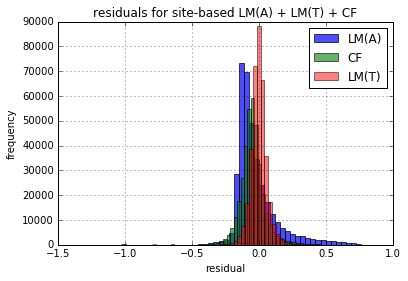

In [19]:
# Let's take a closer look at lm perf for one of our folds.
annotations = list(tfs) + ['strand']
tissues = train_tissues[:]
tissues.remove(closest)

lmd = dict(lmmodels)

guess_lm_annot = sklearn_model(lmd['ElasticNet'], train_df_imp[annotations],
                               train_df_imp[closest], [])
guess_lm = sklearn_model(lmd['ElasticNet'], train_df_imp[tissues],
                         train_df_imp[closest], tissues)
guess_cf = membased_cf(correlation_similarity, train_df_imp[tissues],
                       train_df_imp[closest], tissues)

exact = train_df_imp[closest].iloc[test_ix]

from sklearn.metrics import mean_squared_error
print('rmse lm(A)', math.sqrt(mean_squared_error(exact, guess_lm_annot)))
print('rmse lm(T)', math.sqrt(mean_squared_error(exact, guess_lm)))
print('rmse cf', math.sqrt(mean_squared_error(exact, guess_cf)))

res_lma = guess_lm_annot - exact
res_lmt = guess_lm - exact
res_cf = guess_cf - exact
print('lmt, cf corr', scipy.stats.pearsonr(res_lmt, res_cf))
print('lma, cf corr', scipy.stats.pearsonr(res_lma, res_cf))
print('lma, lmt corr', scipy.stats.pearsonr(res_lma, res_lmt))
plt.hist(res_lma, bins=50, alpha=0.7, label='LM(A)')
plt.hist(res_cf, bins=50, alpha=0.6, label='CF')
plt.hist(res_lmt, bins=50, alpha=0.5, label='LM(T)')
plt.xlabel('residual')
plt.ylabel('frequency')
plt.title('residuals for site-based LM(A) + LM(T) + CF')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
useful_cols = list(train_df_imp.columns)
useful_cols.remove('chromosome')
useful_cols.remove('start')
useful_cols.remove('end')

# grid search narrowed down by printing alpha, l1_ratio from CV on training above
elastic_net = linear_model.ElasticNetCV(l1_ratio=np.arange(.9, 1, .01),
                                        alphas=np.arange(0, 1e-3, 1e-5),
                                        cv=10)
df_with_cf = train_df_int[useful_cols]
guess = ensemble_regression(elastic_net, df_with_cf, test_df['filled'],
                            train_tissues, shallow_copy_cols=False)
exact = test_df['filled'].iloc[test_ix].values

rmse = math.sqrt(mean_squared_error(exact, guess))
acc = correct_half(exact, guess)
r2 = r2_score(exact, guess)
res = guess - exact

print('Ensemble on test: rmse {:04f} methyl acc {:04f} R^2 {:04f}'.format(rmse, acc, r2))

Ensemble on test: rmse 0.059897 methyl acc 0.980256 R^2 0.874534


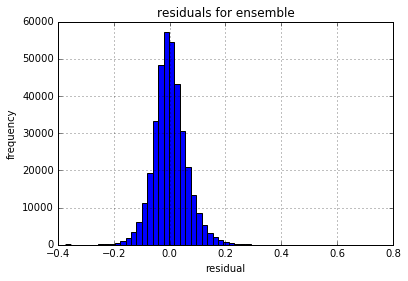

sd ratios [4.6196193481454584, 4.1685941509556192]


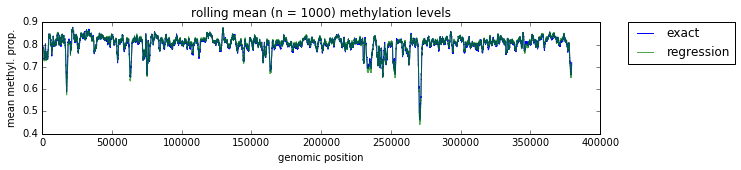

In [21]:
plt.hist(guess - exact, bins=50)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.title('residuals for ensemble')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 2))
ratios = []
plt.title('rolling mean (n = 1000) methylation levels')
plt.xlabel('genomic position')
plt.ylabel('mean methyl. prop.')

ratios = []

x = local_impute(np.copy(test_df['filled']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
actual, = plt.plot(rolled, label='exact')

def full_ensemble_prediction():
    simil = correlation_similarity
    cols = df_with_cf
    similarities = np.array([simil(cols[t].iloc[train_ix],
                                   test_df['filled'].iloc[train_ix])
                             for t in train_tissues])
    k = np.sum(np.fabs(similarities))
    others = cols[train_tissues].values
    cf = pd.Series(others.dot(similarities) / k, index=cols.index)
    cols = cols.copy(deep=False)
    cols['cf'] = cf
    return elastic_net.predict(cols)
x = full_ensemble_prediction()
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
guess, = plt.plot(rolled, label='regression', alpha=0.7)

print('sd ratios', ratios)
plt.legend(handles=[actual,guess])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [22]:
np.isnan(test_df['filled']).sum() / len(test_df), 4.6196193481454584 ** 2

(0.0095296811232219118, 21.34088292175987)

 regularized iterative SVD: for every present user U and some number of factors (dim V)
 $\min \sum_{i,j \in R} (r_{i,j} - \mathbf{U}_i \  \mathbf{V}_j^T) +  \lambda (\sum_i \lVert \mathbf{U}_i \rVert^2   \sum_j \lVert \mathbf{V}_j \rVert^2)$